### Import Required Libraries

En este trabajo, se usa el código base entregado en clase para conseguir hacer un traductor de español a inglés. Para ello, se cambiarán ciertos aspectos del código que se irán comentando para ir adaptándolo a este caso, como puede ser el caso de quitar signos de puntuación que se utilizan en el español (como ¿¡). También se adaptarán las redes neuronales finales y se jugará con la combinación de capas para ver cómo mejora el modelo.

In [1]:
import string
import re
import tensorflow as tf
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd '/content/drive/My Drive/Máster Big Data/Machine Learning II'

# List project directory contents
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Máster Big Data/Machine Learning II
Clases.pages  LabML2_1.2  model.h1.11_may_21		 model.h1.9_may_21
Clases.pdf    LabML2_1.3  model.h1.12_may_21		 __pycache__
dataset       LabML2_1.4  model.h1.13_may_21_corto_LSTM  spa.txt
LabML2_1.1    logs	  model.h1.13_may_21_largo_LSTM


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [5]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [6]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [7]:
data = read_text("spa.txt")
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

### Text Pre-Processing

#### Text Cleaning

Se convierten los datos a DataFrame para hacer más fácil su visualización y análisis.

In [8]:
spa=pd.DataFrame(spa_eng, columns=['English','Español','Fuente'])

In [9]:
spa.head(5)

,English,Español,Fuente
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)


In [ ]:
spa.tail(5)

,English,Español,Fuente
122931,"There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college educ...","Hay madres y padres que se quedan despiertos después de que sus hijos se hayan dormido y se preguntan cómo conseguir pagar la hipoteca o las facturas del médico, o cómo ahorrar el suficiente diner...",CC-BY 2.0 (France) Attribution: tatoeba.org #347771 (CM) & #538643 (Shishir)
122932,A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climat...,Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque está...,CC-BY 2.0 (France) Attribution: tatoeba.org #1141316 (Source_VOA) & #1336787 (marcelostockle)
122933,"Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Goo...","Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a ...",CC-BY 2.0 (France) Attribution: tatoeba.org #954270 (CK) & #1329373 (Shishir)
122934,"If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until t...","Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra ...",CC-BY 2.0 (France) Attribution: tatoeba.org #953962 (CK) & #1218695 (marcelostockle)
122935,"It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages r...","Puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboración. Sin embargo, si animamos a los miembros a contribuir frase...",CC-BY 2.0 (France) Attribution: tatoeba.org #2024159 (CK) & #4463195 (cueyayotl)


Se observa que el dataset está dividido en dos subconjuntos, lo que sería las frases cortas que vemos al principio y que pueden ayudar al contexto de otras frases, y las frases largas que se encuentran al final. Se separa el dataset en dos subconjuntos diferentes para poder hacer diferentes modelos al final con ellos y ver la diferencia de rendimiento de las capas LSTM y GRU. Se empieza a considerar frase larga a partir de 40 caracteres.

In [10]:
for i in range(spa.shape[0]):
  if len(spa.iloc[i,0]) > 40:
    print(i)
    break

97709


In [11]:
spa.iloc[97709,0]

'"Are the drinks free?" "Only for ladies."'

In [12]:
spa_corto=spa.iloc[:97709,:]
spa_largo=spa.iloc[97709:,:]

In [ ]:
print(spa_corto.shape)

(97709, 3)


Se observa que la tercera columna, la columna 'Fuente' no es necesaria para el modelo que se va a desarrollar a continuación. 

In [13]:
spa=spa.iloc[:, [0,1]]
spa_corto=spa_corto.iloc[:, [0,1]]
spa_largo=spa_largo.iloc[:, [0,1]]

In [ ]:
spa.head(5)

,English,Español
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


Una vez que tenemos el análisis hecho, se vuelve a convertir a array.

In [14]:
spa=array(spa)
spa_corto=array(spa_corto)
spa_largo=array(spa_largo)

In [ ]:
spa

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
        'Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante.'],
       ['If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.',
        'Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y

In [15]:
# Remove punctuation
spa[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa[:,0]]
spa[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa[:,1]]
spa_corto[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_corto[:,0]]
spa_corto[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_corto[:,1]]
spa_largo[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_largo[:,0]]
spa_largo[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_largo[:,1]]

#Quitamos también las exclamaciones e interrogaciones
spa[:,1]=[s.translate(str.maketrans('', '', '¡')) for s in spa[:,1]]
spa[:,1]=[s.translate(str.maketrans('', '', '¿')) for s in spa[:,1]]
spa_corto[:,1]=[s.translate(str.maketrans('', '', '¡')) for s in spa_corto[:,1]]
spa_corto[:,1]=[s.translate(str.maketrans('', '', '¿')) for s in spa_corto[:,1]]
spa_largo[:,1]=[s.translate(str.maketrans('', '', '¡')) for s in spa_largo[:,1]]
spa_largo[:,1]=[s.translate(str.maketrans('', '', '¿')) for s in spa_largo[:,1]]

Hay que tener en cuenta los caracteres que se utilizan en el español que en el inglés no se encuentran, por ejemplo, los inicios de exclamación e interrogación.

In [ ]:
spa

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['Since there are usually multiple websites on any given topic I usually just click the back button when I arrive on any webpage that has popup advertising I just go to the next page found by Google and hope for something less irritating',
        'Como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes Simplemente voy a la siguiente página encontrada por Google y espero encontrar algo menos irritante'],
       ['If you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'Si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

In [16]:
# convert to lowercase
for i in range(len(spa)):
    spa[i,0] = spa[i,0].lower()

    
    spa[i,1] = spa[i,1].lower()


for i in range(len(spa_corto)):
  spa_corto[i,0] = spa_corto[i,0].lower()

    
  spa_corto[i,1] = spa_corto[i,1].lower()

for i in range(len(spa_largo)):
  spa_largo[i,0] = spa_largo[i,0].lower()

    
  spa_largo[i,1] = spa_largo[i,1].lower()

In [ ]:
spa

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating',
        'como suele haber varias páginas web sobre cualquier tema normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente página encontrada por google y espero encontrar algo menos irritante'],
       ['if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo',
        'si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la 

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [17]:
# empty lists
eng_l = []
spa_l = []
eng_l_corto=[]
spa_l_corto=[]
eng_l_largo=[]
spa_l_largo=[]

# populate the lists with sentence lengths
for i in spa[:,0]:
    eng_l.append(len(i.split()))

for i in spa[:,1]:
    spa_l.append(len(i.split()))


for i in spa_corto[:,0]:
    eng_l_corto.append(len(i.split()))

for i in spa_corto[:,1]:
    spa_l_corto.append(len(i.split()))

for i in spa_largo[:,0]:
    eng_l_largo.append(len(i.split()))

for i in spa_largo[:,1]:
    spa_l_largo.append(len(i.split()))

In [18]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
length_df2=pd.DataFrame({'eng':eng_l_corto, 'spa':spa_l_corto})
length_df3=pd.DataFrame({'eng':eng_l_largo, 'spa':spa_l_largo})
#print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))
print(max(length_df2.eng))
print(max(length_df2.spa))
print(max(length_df3.eng))
print(max(length_df3.spa))

47
53
11
15
47
53


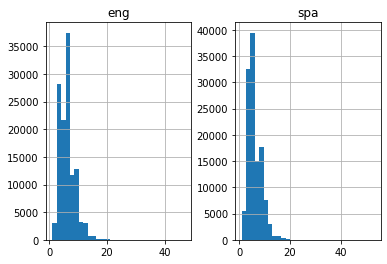

In [ ]:
length_df.hist(bins = 30)
plt.show()

La máxima longitud para frases en español es de 53, mientras que para las frases en inglés es de 47.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [19]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_tokenizer_corto = tokenization(spa_corto[:, 0])
eng_vocab_size_corto = len(eng_tokenizer_corto.word_index) + 1
eng_tokenizer_largo = tokenization(spa_largo[:, 0])
eng_vocab_size_largo = len(eng_tokenizer_largo.word_index) + 1

eng_length = 47
eng_length_corto=11
eng_length_largo=47
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13731


In [21]:
# prepare Deutch tokenizer
spa_tokenizer = tokenization(spa[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1
spa_tokenizer_corto = tokenization(spa_corto[:, 1])
spa_vocab_size_corto = len(spa_tokenizer_corto.word_index) + 1
spa_tokenizer_largo = tokenization(spa_largo[:, 1])
spa_vocab_size_largo = len(spa_tokenizer_largo.word_index) + 1

spa_length = 53
spa_length_corto=15
spa_length_largo=53
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 26506


In [ ]:
#print(spa_tokenizer.word_counts)

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively. Dividimos el dataset en los conjuntos de test y entrenamiento, para todos los casos de dataset que se han creado.

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa, test_size=0.2, random_state = 12)
train2, test2= train_test_split(spa_corto, test_size=0.2, random_state=12)
train3, test3= train_test_split(spa_largo, test_size=0.2, random_state=12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [24]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainX2 = encode_sequences(spa_tokenizer_corto, spa_length_corto, train2[:, 1])
trainY2 = encode_sequences(eng_tokenizer_corto, eng_length_corto, train2[:, 0])
trainX3 = encode_sequences(spa_tokenizer_largo, spa_length_largo, train3[:, 1])
trainY3 = encode_sequences(eng_tokenizer_largo, eng_length_largo, train3[:, 0])

[[  103    54    30 ...     0     0     0]
 [    6  1118 14694 ...     0     0     0]
 [    3   121  4191 ...     0     0     0]
 ...
 [   58   303  2338 ...     0     0     0]
 [    3   269   789 ...     0     0     0]
 [   21   124  1799 ...     0     0     0]]
98348
[[  44   22   86 ...    0    0    0]
 [8196 1181    7 ...    0    0    0]
 [   2   56   31 ...    0    0    0]
 ...
 [  74  470  836 ...    0    0    0]
 [   2  219   68 ...    0    0    0]
 [  17  156 1081 ...    0    0    0]]
98348
[[ 1098    10  1087 ...     0     0     0]
 [  685  1283 11625 ...     0     0     0]
 [   86   183     0 ...     0     0     0]
 ...
 [   15   305   104 ...     0     0     0]
 [   55   268  1971 ...     0     0     0]
 [   19   125  1627 ...     0     0     0]]
78167
[[ 49  16  67 ...   0   0   0]
 [135  12  33 ...   0   0   0]
 [  9   2  18 ...   0   0   0]
 ...
 [  2 128   9 ...   0   0   0]
 [ 61 465 682 ...   0   0   0]
 [ 15 157 946 ...   0   0   0]]
78167
[[  92  278  148 ...    0   

In [ ]:
print(trainX.shape)
print(trainY.shape)

(98348, 53)
(98348, 47)


In [25]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testX2 = encode_sequences(spa_tokenizer_corto, spa_length_corto, test2[:, 1])
testY2 = encode_sequences(eng_tokenizer_corto, eng_length_corto, test2[:, 0])
testX3 = encode_sequences(spa_tokenizer_largo, spa_length_largo, test3[:, 1])
testY3 = encode_sequences(eng_tokenizer_largo, eng_length_largo, test3[:, 0])

[[  23   56 4602 ...    0    0    0]
 [  11  165  239 ...    0    0    0]
 [   9  196    2 ...    0    0    0]
 ...
 [  14  132   16 ...    0    0    0]
 [  24  253   15 ...    0    0    0]
 [ 501  908  113 ...    0    0    0]]
24588
[[  21   42 3163 ...    0    0    0]
 [ 161   35    3 ...    0    0    0]
 [   8    7  224 ...    0    0    0]
 ...
 [   8   54    6 ...    0    0    0]
 [  21  150  532 ...    0    0    0]
 [   2  291    2 ...    0    0    0]]
24588
[[   1  157    6 ...    0    0    0]
 [  14   18  101 ...    0    0    0]
 [  13   17 6576 ...    0    0    0]
 ...
 [  18 5835    4 ...    0    0    0]
 [ 359 2883    0 ...    0    0    0]
 [  18  737   61 ...    0    0    0]]
19542
[[   5  258    4 ...    0    0    0]
 [  62   21    2 ...    0    0    0]
 [  45  327 2259 ...    0    0    0]
 ...
 [  23 4808 1813 ...    0    0    0]
 [  61 2032    0 ...    0    0    0]
 [  23   92    4 ...    0    0    0]]
19542
[[   6  363 4584 ...    0    0    0]
 [   5 1938 1378 ...    0  

In [ ]:
print(testX.shape)
print(testY.shape)

(24588, 53)
(24588, 47)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [26]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [27]:
def build_model2(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
def build_model3(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Se crean tres tipos diferentes de modelos para comprobar las diferencias que existen entre LSTM y GRU mayoritariamente. Se entrenará cada uno de los dos primeros modelos con los dataset de frases cortas y largas para ver también las diferencias entre emplear una LSTM (por ejemplo) con frases cortas y con frases largas. El último modelo se probará con el dataset original para comprobar cómo funcionan ambas capas apiladas.

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [ ]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

26506
13731
53
47


In [ ]:
model = build_model(spa_vocab_size_largo, eng_vocab_size_largo, spa_length_largo, eng_length_largo, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.13_may_21_corto_LSTM'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX2, trainY2.reshape(trainY2.shape[0], trainY2.shape[1], 1), 
          epochs=20, steps_per_epoch=25, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
25/25 [==============================] - 10s 221ms/step - loss: 5.7812 - val_loss: 3.4976

Epoch 00001: val_loss improved from inf to 3.49756, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 2/20
25/25 [==============================] - 4s 173ms/step - loss: 3.4312 - val_loss: 3.2388

Epoch 00002: val_loss improved from 3.49756 to 3.23881, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 3/20
25/25 [==============================] - 4s 172ms/step - loss: 3.2381 - val_loss: 3.2080

Epoch 00003: val_loss improved from 3.23881 to 3.20802, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 4/20
25/25 [==============================] - 4s 173ms/step - loss: 3.1996 - val_loss: 3.1164

Epoch 00004: val_loss improved from 3.20802 to 3.11642, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 5/20
25/25 [==============================] - 4s 173ms/step - loss: 3.1329 - val_loss: 3.0827

Epoch 00005: val_loss improved from 3.11642 to 3.08266, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 6/20
25/25 [==============================] - 4s 175ms/step - loss: 3.0525 - val_loss: 3.0894

Epoch 00006: val_loss did not improve from 3.08266
Epoch 7/20
25/25 [==============================] - 4s 174ms/step - loss: 3.0387 - val_loss: 3.0384

Epoch 00007: val_loss improved from 3.08266 to 3.03843, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 8/20
25/25 [==============================] - 4s 175ms/step - loss: 3.0081 - val_loss: 2.9702

Epoch 00008: val_loss improved from 3.03843 to 2.97019, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 9/20
25/25 [==============================] - 4s 175ms/step - loss: 2.9520 - val_loss: 2.9594

Epoch 00009: val_loss improved from 2.97019 to 2.95939, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 10/20
25/25 [==============================] - 4s 171ms/step - loss: 2.9296 - val_loss: 2.9321

Epoch 00010: val_loss improved from 2.95939 to 2.93215, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 11/20
25/25 [==============================] - 4s 171ms/step - loss: 2.8745 - val_loss: 2.9104

Epoch 00011: val_loss improved from 2.93215 to 2.91041, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 12/20
25/25 [==============================] - 4s 173ms/step - loss: 2.8341 - val_loss: 2.9004

Epoch 00012: val_loss improved from 2.91041 to 2.90040, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 13/20
25/25 [==============================] - 4s 175ms/step - loss: 2.8130 - val_loss: 2.8686

Epoch 00013: val_loss improved from 2.90040 to 2.86864, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 14/20
25/25 [==============================] - 4s 176ms/step - loss: 2.8248 - val_loss: 2.8339

Epoch 00014: val_loss improved from 2.86864 to 2.83395, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 15/20
25/25 [==============================] - 4s 171ms/step - loss: 2.8073 - val_loss: 2.8040

Epoch 00015: val_loss improved from 2.83395 to 2.80404, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 16/20
25/25 [==============================] - 4s 174ms/step - loss: 2.6924 - val_loss: 2.7548

Epoch 00016: val_loss improved from 2.80404 to 2.75485, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 17/20
25/25 [==============================] - 4s 175ms/step - loss: 2.7036 - val_loss: 2.7470

Epoch 00017: val_loss improved from 2.75485 to 2.74698, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 18/20
25/25 [==============================] - 4s 176ms/step - loss: 2.6656 - val_loss: 2.7030

Epoch 00018: val_loss improved from 2.74698 to 2.70302, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 19/20
25/25 [==============================] - 4s 176ms/step - loss: 2.6566 - val_loss: 2.6487

Epoch 00019: val_loss improved from 2.70302 to 2.64867, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Epoch 20/20
25/25 [==============================] - 4s 170ms/step - loss: 2.5787 - val_loss: 2.6262

Epoch 00020: val_loss improved from 2.64867 to 2.62619, saving model to model.h1.13_may_21_corto_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_LSTM/assets


Let's compare the training loss and the validation loss.

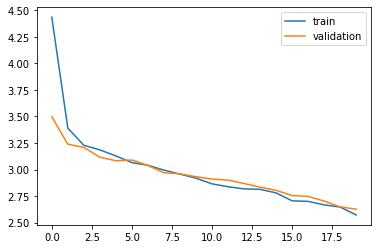

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Se observa que el resultado con este primer modelo de LSTM con frases cortas es bastante satisfactorio porque no tiene sobreentrenamiento, pero si observamos sus valores de función de pérdida, todavía son un poco altos. Esto se puede deber a la elección de frases cortas en este caso. A continuación, se entrena el mismo modelo, pero esta vez con el dataset de frases largas.

In [ ]:
model = build_model(spa_vocab_size_largo, eng_vocab_size_largo, spa_length_largo, eng_length_largo, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.13_may_21_largo_LSTM'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX3, trainY3.reshape(trainY3.shape[0], trainY3.shape[1], 1), 
          epochs=20, steps_per_epoch=25, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
25/25 [==============================] - 15s 459ms/step - loss: 4.2102 - val_loss: 1.5776

Epoch 00001: val_loss improved from inf to 1.57762, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 2/20
25/25 [==============================] - 10s 398ms/step - loss: 1.5751 - val_loss: 1.5327

Epoch 00002: val_loss improved from 1.57762 to 1.53269, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 3/20
25/25 [==============================] - 10s 403ms/step - loss: 1.5048 - val_loss: 1.4772

Epoch 00003: val_loss improved from 1.53269 to 1.47723, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 4/20
25/25 [==============================] - 10s 403ms/step - loss: 1.4557 - val_loss: 1.4511

Epoch 00004: val_loss improved from 1.47723 to 1.45106, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 5/20
25/25 [==============================] - 10s 412ms/step - loss: 1.4232 - val_loss: 1.4375

Epoch 00005: val_loss improved from 1.45106 to 1.43751, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 6/20
25/25 [==============================] - 10s 407ms/step - loss: 1.4143 - val_loss: 1.4448

Epoch 00006: val_loss did not improve from 1.43751
Epoch 7/20
25/25 [==============================] - 10s 409ms/step - loss: 1.4039 - val_loss: 1.4301

Epoch 00007: val_loss improved from 1.43751 to 1.43010, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 8/20
25/25 [==============================] - 10s 410ms/step - loss: 1.3828 - val_loss: 1.4327

Epoch 00008: val_loss did not improve from 1.43010
Epoch 9/20
25/25 [==============================] - 10s 412ms/step - loss: 1.3723 - val_loss: 1.3904

Epoch 00009: val_loss improved from 1.43010 to 1.39043, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 10/20
25/25 [==============================] - 10s 418ms/step - loss: 1.3501 - val_loss: 1.3944

Epoch 00010: val_loss did not improve from 1.39043
Epoch 11/20
25/25 [==============================] - 10s 415ms/step - loss: 1.3395 - val_loss: 1.3746

Epoch 00011: val_loss improved from 1.39043 to 1.37465, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 12/20
25/25 [==============================] - 10s 412ms/step - loss: 1.3306 - val_loss: 1.3724

Epoch 00012: val_loss improved from 1.37465 to 1.37237, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 13/20
25/25 [==============================] - 10s 414ms/step - loss: 1.3126 - val_loss: 1.3518

Epoch 00013: val_loss improved from 1.37237 to 1.35180, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 14/20
25/25 [==============================] - 10s 419ms/step - loss: 1.2946 - val_loss: 1.3477

Epoch 00014: val_loss improved from 1.35180 to 1.34765, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 15/20
25/25 [==============================] - 10s 413ms/step - loss: 1.2788 - val_loss: 1.3621

Epoch 00015: val_loss did not improve from 1.34765
Epoch 16/20
25/25 [==============================] - 10s 417ms/step - loss: 1.2700 - val_loss: 1.3260

Epoch 00016: val_loss improved from 1.34765 to 1.32602, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


Epoch 17/20
25/25 [==============================] - 10s 417ms/step - loss: 1.2563 - val_loss: 1.3293

Epoch 00017: val_loss did not improve from 1.32602
Epoch 18/20
25/25 [==============================] - 10s 418ms/step - loss: 1.2476 - val_loss: 1.3344

Epoch 00018: val_loss did not improve from 1.32602
Epoch 19/20
25/25 [==============================] - 11s 428ms/step - loss: 1.2402 - val_loss: 1.3266

Epoch 00019: val_loss did not improve from 1.32602
Epoch 20/20
25/25 [==============================] - 10s 422ms/step - loss: 1.2248 - val_loss: 1.3231

Epoch 00020: val_loss improved from 1.32602 to 1.32309, saving model to model.h1.13_may_21_largo_LSTM


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_LSTM/assets


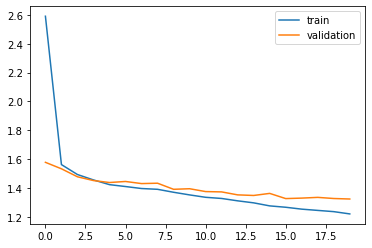

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Comparando con el modelo anterior, se considera este último como mejor modelo, ya que la función de pérdida toma valores menores en este caso, lo que significa una mejor precisión del modelo. En las últimas épocas se podría pensar viendo la gráfica que existe sobreentrenamiento, pero esto no es así, ya que si nos fijamos en la escala de la gráfica, son valores muy próximos entre sí. 

El siguiente modelo a entrenar será el modelo de GRUs con el dataset de frases cortas. Se deduce que este podría tener un mejor comportamiento que el modelo anterior de frases cortas debido a las características de la GRU, ideal para frases cortas con entrenamientos rápidos del modelo.

In [ ]:
model = build_model2(spa_vocab_size_corto, eng_vocab_size_corto, spa_length_corto, eng_length_corto, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.13_may_21_corto_gru'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX2, trainY2.reshape(trainY2.shape[0], trainY2.shape[1], 1), 
          epochs=20, steps_per_epoch=25, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
25/25 [==============================] - 38s 172ms/step - loss: 5.6518 - val_loss: 3.4887

Epoch 00001: val_loss improved from inf to 3.48869, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 2/20
25/25 [==============================] - 3s 118ms/step - loss: 3.4503 - val_loss: 3.2831

Epoch 00002: val_loss improved from 3.48869 to 3.28308, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 3/20
25/25 [==============================] - 3s 120ms/step - loss: 3.2537 - val_loss: 3.1793

Epoch 00003: val_loss improved from 3.28308 to 3.17932, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 4/20
25/25 [==============================] - 3s 121ms/step - loss: 3.1712 - val_loss: 3.1536

Epoch 00004: val_loss improved from 3.17932 to 3.15355, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 5/20
25/25 [==============================] - 3s 123ms/step - loss: 3.1266 - val_loss: 3.0923

Epoch 00005: val_loss improved from 3.15355 to 3.09227, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 6/20
25/25 [==============================] - 3s 120ms/step - loss: 3.0501 - val_loss: 3.0827

Epoch 00006: val_loss improved from 3.09227 to 3.08271, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 7/20
25/25 [==============================] - 3s 123ms/step - loss: 2.9998 - val_loss: 2.9628

Epoch 00007: val_loss improved from 3.08271 to 2.96284, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 8/20
25/25 [==============================] - 3s 124ms/step - loss: 2.9459 - val_loss: 2.9136

Epoch 00008: val_loss improved from 2.96284 to 2.91364, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 9/20
25/25 [==============================] - 3s 121ms/step - loss: 2.8823 - val_loss: 2.8826

Epoch 00009: val_loss improved from 2.91364 to 2.88258, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 10/20
25/25 [==============================] - 3s 123ms/step - loss: 2.8512 - val_loss: 2.8242

Epoch 00010: val_loss improved from 2.88258 to 2.82424, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 11/20
25/25 [==============================] - 3s 124ms/step - loss: 2.7658 - val_loss: 2.7948

Epoch 00011: val_loss improved from 2.82424 to 2.79479, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 12/20
25/25 [==============================] - 3s 122ms/step - loss: 2.7488 - val_loss: 2.7748

Epoch 00012: val_loss improved from 2.79479 to 2.77481, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 13/20
25/25 [==============================] - 3s 121ms/step - loss: 2.7346 - val_loss: 2.7273

Epoch 00013: val_loss improved from 2.77481 to 2.72727, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 14/20
25/25 [==============================] - 3s 121ms/step - loss: 2.7062 - val_loss: 2.6729

Epoch 00014: val_loss improved from 2.72727 to 2.67292, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 15/20
25/25 [==============================] - 3s 120ms/step - loss: 2.6165 - val_loss: 2.6658

Epoch 00015: val_loss improved from 2.67292 to 2.66577, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 16/20
25/25 [==============================] - 3s 124ms/step - loss: 2.5801 - val_loss: 2.6077

Epoch 00016: val_loss improved from 2.66577 to 2.60769, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 17/20
25/25 [==============================] - 3s 123ms/step - loss: 2.5231 - val_loss: 2.5809

Epoch 00017: val_loss improved from 2.60769 to 2.58090, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 18/20
25/25 [==============================] - 3s 124ms/step - loss: 2.5165 - val_loss: 2.5620

Epoch 00018: val_loss improved from 2.58090 to 2.56198, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 19/20
25/25 [==============================] - 3s 125ms/step - loss: 2.4709 - val_loss: 2.4873

Epoch 00019: val_loss improved from 2.56198 to 2.48729, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


Epoch 20/20
25/25 [==============================] - 3s 119ms/step - loss: 2.4239 - val_loss: 2.4332

Epoch 00020: val_loss improved from 2.48729 to 2.43322, saving model to model.h1.13_may_21_corto_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_corto_gru/assets


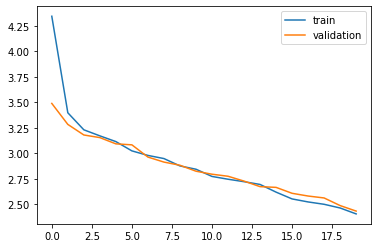

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Se muestra una ligera mejoría con respecto al primer modelo. Se esperaba un mejor rendimiento de este tipo de modelo con frases cortas, y lo que puede haber ocurrido es que las frases siguen siendo demasiado largas como para conseguir un buen rendimiento de las GRU. 

El próximo modelo se trata de un modelo de GRUs pero en este caso entrenado con el dataset de frases largas. Se espera que el rendimiento de este modelo sea peor al mostrado en el último modelo debido a la longitud de las frases.

In [ ]:
model = build_model2(spa_vocab_size_largo, eng_vocab_size_largo, spa_length_largo, eng_length_largo, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
filename = 'model.h1.13_may_21_largo_gru'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX3, trainY3.reshape(trainY3.shape[0], trainY3.shape[1], 1), 
          epochs=20, steps_per_epoch=25, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
25/25 [==============================] - 12s 300ms/step - loss: 4.1956 - val_loss: 1.6529

Epoch 00001: val_loss improved from inf to 1.65288, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 2/20
25/25 [==============================] - 6s 243ms/step - loss: 1.5835 - val_loss: 1.5239

Epoch 00002: val_loss improved from 1.65288 to 1.52393, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 3/20
25/25 [==============================] - 6s 245ms/step - loss: 1.5021 - val_loss: 1.4860

Epoch 00003: val_loss improved from 1.52393 to 1.48602, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 4/20
25/25 [==============================] - 6s 244ms/step - loss: 1.4712 - val_loss: 1.4748

Epoch 00004: val_loss improved from 1.48602 to 1.47483, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 5/20
25/25 [==============================] - 6s 248ms/step - loss: 1.4485 - val_loss: 1.4497

Epoch 00005: val_loss improved from 1.47483 to 1.44967, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 6/20
25/25 [==============================] - 6s 244ms/step - loss: 1.4195 - val_loss: 1.4475

Epoch 00006: val_loss improved from 1.44967 to 1.44751, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 7/20
25/25 [==============================] - 6s 245ms/step - loss: 1.4051 - val_loss: 1.4131

Epoch 00007: val_loss improved from 1.44751 to 1.41314, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 8/20
25/25 [==============================] - 6s 246ms/step - loss: 1.3777 - val_loss: 1.3790

Epoch 00008: val_loss improved from 1.41314 to 1.37899, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 9/20
25/25 [==============================] - 6s 245ms/step - loss: 1.3515 - val_loss: 1.3691

Epoch 00009: val_loss improved from 1.37899 to 1.36909, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 10/20
25/25 [==============================] - 6s 249ms/step - loss: 1.3384 - val_loss: 1.4087

Epoch 00010: val_loss did not improve from 1.36909
Epoch 11/20
25/25 [==============================] - 6s 247ms/step - loss: 1.3367 - val_loss: 1.3842

Epoch 00011: val_loss did not improve from 1.36909
Epoch 12/20
25/25 [==============================] - 6s 244ms/step - loss: 1.3331 - val_loss: 1.3784

Epoch 00012: val_loss did not improve from 1.36909
Epoch 13/20
25/25 [==============================] - 6s 244ms/step - loss: 1.3029 - val_loss: 1.3659

Epoch 00013: val_loss improved from 1.36909 to 1.36586, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 14/20
25/25 [==============================] - 6s 248ms/step - loss: 1.3158 - val_loss: 1.3908

Epoch 00014: val_loss did not improve from 1.36586
Epoch 15/20
25/25 [==============================] - 6s 246ms/step - loss: 1.2898 - val_loss: 1.3494

Epoch 00015: val_loss improved from 1.36586 to 1.34937, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 16/20
25/25 [==============================] - 6s 243ms/step - loss: 1.2772 - val_loss: 1.3217

Epoch 00016: val_loss improved from 1.34937 to 1.32169, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 17/20
25/25 [==============================] - 6s 244ms/step - loss: 1.2598 - val_loss: 1.3054

Epoch 00017: val_loss improved from 1.32169 to 1.30535, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 18/20
25/25 [==============================] - 6s 245ms/step - loss: 1.2361 - val_loss: 1.3337

Epoch 00018: val_loss did not improve from 1.30535
Epoch 19/20
25/25 [==============================] - 6s 249ms/step - loss: 1.2263 - val_loss: 1.2985

Epoch 00019: val_loss improved from 1.30535 to 1.29855, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


Epoch 20/20
25/25 [==============================] - 6s 245ms/step - loss: 1.2059 - val_loss: 1.2956

Epoch 00020: val_loss improved from 1.29855 to 1.29564, saving model to model.h1.13_may_21_largo_gru


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


INFO:tensorflow:Assets written to: model.h1.13_may_21_largo_gru/assets


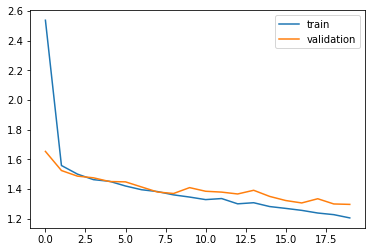

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

El comportamiento obtenido con este modelo es un poco inesperado por lo comentado en clase respecto a este tipo de capas. Una posible explicación de este comportamiento puede estar en el apilamiento de varias capas de GRU como se ha hecho, mejorando la "memoria" del modelo para retener información de las frases.

El último modelo que se pone a entrenar se trata del modelo creado con capas apiladas tanto de LSTM como de GRU, para probar a ver qué tal funciona.

In [29]:
model = build_model3(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [30]:
filename = 'model.h1.14_may_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=20, steps_per_epoch=25, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
25/25 [==============================] - 63s 1s/step - loss: 3.6278 - val_loss: 1.0308

Epoch 00001: val_loss improved from inf to 1.03081, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 2/20
25/25 [==============================] - 24s 979ms/step - loss: 1.0249 - val_loss: 0.9694

Epoch 00002: val_loss improved from 1.03081 to 0.96936, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 3/20
25/25 [==============================] - 25s 997ms/step - loss: 0.9644 - val_loss: 0.9355

Epoch 00003: val_loss improved from 0.96936 to 0.93546, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 4/20
25/25 [==============================] - 26s 1s/step - loss: 0.9298 - val_loss: 0.9063

Epoch 00004: val_loss improved from 0.93546 to 0.90627, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 5/20
25/25 [==============================] - 26s 1s/step - loss: 0.9137 - val_loss: 0.9114

Epoch 00005: val_loss did not improve from 0.90627
Epoch 6/20
25/25 [==============================] - 27s 1s/step - loss: 0.8941 - val_loss: 0.8734

Epoch 00006: val_loss improved from 0.90627 to 0.87335, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 7/20
25/25 [==============================] - 27s 1s/step - loss: 0.8817 - val_loss: 0.8896

Epoch 00007: val_loss did not improve from 0.87335
Epoch 8/20
25/25 [==============================] - 27s 1s/step - loss: 0.8773 - val_loss: 0.8706

Epoch 00008: val_loss improved from 0.87335 to 0.87056, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 9/20
25/25 [==============================] - 27s 1s/step - loss: 0.8735 - val_loss: 0.8836

Epoch 00009: val_loss did not improve from 0.87056
Epoch 10/20
25/25 [==============================] - 28s 1s/step - loss: 0.8658 - val_loss: 0.8727

Epoch 00010: val_loss did not improve from 0.87056
Epoch 11/20
25/25 [==============================] - 26s 1s/step - loss: 0.8681 - val_loss: 0.9202

Epoch 00011: val_loss did not improve from 0.87056
Epoch 12/20
25/25 [==============================] - 26s 1s/step - loss: 0.8692 - val_loss: 0.8820

Epoch 00012: val_loss did not improve from 0.87056
Epoch 13/20
25/25 [==============================] - 27s 1s/step - loss: 0.8608 - val_loss: 0.8600

Epoch 00013: val_loss improved from 0.87056 to 0.85996, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 14/20
25/25 [==============================] - 27s 1s/step - loss: 0.8422 - val_loss: 0.8410

Epoch 00014: val_loss improved from 0.85996 to 0.84096, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 15/20
25/25 [==============================] - 27s 1s/step - loss: 0.8359 - val_loss: 0.8297

Epoch 00015: val_loss improved from 0.84096 to 0.82970, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 16/20
25/25 [==============================] - 27s 1s/step - loss: 0.8317 - val_loss: 0.8520

Epoch 00016: val_loss did not improve from 0.82970
Epoch 17/20
25/25 [==============================] - 27s 1s/step - loss: 0.8316 - val_loss: 0.8145

Epoch 00017: val_loss improved from 0.82970 to 0.81446, saving model to model.h1.14_may_21


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


INFO:tensorflow:Assets written to: model.h1.14_may_21/assets


Epoch 18/20
25/25 [==============================] - 27s 1s/step - loss: 0.8235 - val_loss: 0.8318

Epoch 00018: val_loss did not improve from 0.81446
Epoch 19/20
25/25 [==============================] - 28s 1s/step - loss: 0.8204 - val_loss: 0.8237

Epoch 00019: val_loss did not improve from 0.81446
Epoch 20/20
25/25 [==============================] - 26s 1s/step - loss: 0.8115 - val_loss: 0.8151

Epoch 00020: val_loss did not improve from 0.81446


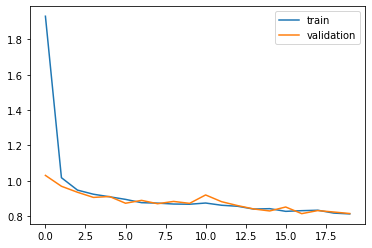

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Como se puede observar, los resultados obtenidos son más que satisfactorios, con una pérdida muy inferior a todos los modelos anteriores y sin sobreentrenamiento. Este modelo se podría mejorar metiéndole más épocas, pero para el caso de estudio de este trabajo, con 25 épocas era suficiente para ver los efectos de los distintos modelos.

Let's load the saved model to make predictions.

In [32]:
model = load_model('model.h1.14_may_21')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))

InternalError: ignored

No se ha podido hacer el predict debido al fallo que se obtiene. Además, al ser un dataset tan grande, se come la RAM y se reinicia el entorno de Jupyter (en local) y en Colab directamente te reinicia el entorno de ejecución, por lo que no deja hacer predicciones.

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.tail(15)

In [ ]:
pred_df.sample(15)

#CONCLUSIONES

Se ha querido comprobar las características comentadas en clase acerca de las capas LSTM y GRU, y tras los resultados obtenidos, se observa que no ha variado mucho los valores de un modelo a otro. Esto puede deberse al apilamiento de capas, que hace que el modelo de GRUs tenga más "memoria" que sólo teniendo una capa de este tipo.

Por último, se ha probado a apilar capas de distinto tipo siguiendo una de las recomendaciones para la mejoras de modelos que se ha visto en clase, y se ha llegado a unos resultados muy buenos al haber apilado dos capas LSTM con dos capas GRU. Este modelo tendrá tanto memoria a largo como a corto plazo por los dos tipos de capas escogidas, con la ventaja del control de vanishing gradient mediante la capa LSTM.

Uno de los puntos a seguir en trabajos futuros podría ser la creación de un modelo con capas convolucionales 1 D combinadas con RNN, o algunas capas neuronales más avanzadas similares a LSTM y GRU, que prueban otras configuraciones de puerta de olvido, de entrada, etc.